In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Recommendation systems: Deep Model

This model is made up of feature layers that have users, movies and movie genres embedings followed by a neural network with dense layers and finally one output that is the rating prediction that input user(id) could assign to input movie(id).

**Inputs**
* **User id**: Really this is traducet as a sequence because embedding layers only can manage sequenced identifiers.
* **Movie id**: Idem to User id.
* **Movie genres**: One column by genre.

**Output**
*  **Rating prediction** that user could assign to movie.

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Movie lens datasets](https://grouplens.org/datasets/movielens/)
* [Recommendation Systems Benchmarks](https://paperswithcode.com/task/recommendation-systems)

## Required libraries

In [2]:
import os

def show_env_var(varname):
    if varname in os.environ:
        print(f'{varname}: {os.environ[varname]}')
    else:
        print(f'{varname} undefined')

show_env_var('MODIN_OUT_OF_CORE')
show_env_var('MODIN_MEMORY')
show_env_var('MODIN_ON_RAY_PLASMA_DIR')

MODIN_OUT_OF_CORE: true
MODIN_MEMORY: 500000000
MODIN_ON_RAY_PLASMA_DIR: /home/adrian/tmp


In [3]:
import sys
sys.path.append('../src')

import ray
import modin

import pandas as pd
# import modin.pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import kerastuner as kt

from util import tf_detected_devices, tf_version, plot_model, Config, LoggerFactory, create_path

from callback import MetricsPlotter
from data import InMemoryXyDataGenerator
from recommendation import UserMovieGenderEmbeddingDenseModelFactory

from util import create_path, remove_dir

import warnings
warnings.filterwarnings("ignore")

In [4]:
modin.__version__

'0.8.3'

In [5]:
# ray.shutdown()

In [6]:
#if not ray.is_initialized():
#    ray.init(num_cpus=24, num_gpus=1, dashboard_host="0.0.0.0", dashboard_port=8080)
#else:
#    print('Ray is already active!')

## Logger config

In [7]:
config = Config(path='../config/config.yaml')
LoggerFactory(config['logger']).create()

<RootLogger root (INFO)>

## Check environment

**Step 1**: Make sure that nvidia driver is installed runing next command:

In [8]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce RTX 3080, 10010 MiB


**Note:** If this shows a GPU model and memory size, that's all right, otherwise make suze that has the nvidia driver installed.

**Step 2**: Let's check tensorflow version:

In [9]:
tf_version()

'Tensorflow version: 2.4.1'

**Step 3**: Let's check devices that tensorflow detect:

In [10]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:GPU:0,GPU,8G,"device: 0, name: GeForce RTX 3080, pci bus id:..."


In [11]:
tf.debugging.set_log_device_placement(False)

**Step 4**: Make sure that tensorflow detect cuda libs and GPU devices.

In [12]:
tf.test.is_built_with_cuda()

True

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Prepare model input data

In [14]:
TEMP_PATH = './temp'
TRAIN_PATH = f'{TEMP_PATH}/train'
VAL_PATH = f'{TEMP_PATH}/val'
TEST_PATH = f'{TEMP_PATH}/test'

In [15]:
import glob

def read_csv(path):
    all_files = glob.glob(path)
    li = [pd.read_csv(filename, index_col=None, header=0) for filename in all_files]
    return pd.concat(li, axis=0, ignore_index=True)

In [16]:
train_set = read_csv(f'{TRAIN_PATH}/*.csv')

In [17]:
val_set = read_csv(f'{VAL_PATH}/*.csv')

In [18]:
test_set = read_csv(f'{TEST_PATH}/*.csv')

In [19]:
print(f'Train set size: {"{:,}".format(train_set.shape[0])} samples.')
print(f'Validation set size: {"{:,}".format(val_set.shape[0])} samples.')
print(f'Test set size: {"{:,}".format(test_set.shape[0])} samples.')

Train set size: 3,498,313 samples.
Validation set size: 303,318 samples.
Test set size: 193,460 samples.


**Step 3:** Let's see min and max value of rating column.

In [20]:
min_rating, max_rating = train_set['rating'].min(), train_set['rating'].max()

print('Rattings:\n - min:', min_rating, '\n - max:', max_rating)

Rattings:
 - min: 0.5 
 - max: 5.0


Calculate train, val batch_size and plot interval.

In [21]:
import math

steps             = 100
epochs            = 80
plot_interval     = math.floor(steps / 2)

train_batch_size  = math.floor(train_set.shape[0] / steps)
val_batch_size    = math.floor(val_set.shape[0] / steps)
evaluate_interval = plot_interval + 1

In [22]:
print(f'Train Batch Size      : {"{:,}".format(train_batch_size)}.')
print(f'Validation Batch Size : {"{:,}".format(val_batch_size)}.')
print('Plot Interval         :', plot_interval)
print('Evaluate Interval     :', evaluate_interval)
print('Epochs                :', epochs)

Train Batch Size      : 34,983.
Validation Batch Size : 3,033.
Plot Interval         : 50
Evaluate Interval     : 51
Epochs                : 80


In [23]:
X_train = train_set[list(set(train_set.columns) - set(['user_id', 'movie_id', 'rating']))].values
y_train = train_set['rating'].values

In [24]:
X_val = val_set[list(set(val_set.columns) - set(['user_id', 'movie_id', 'rating']))].values
y_val = val_set['rating'].values

In [25]:
X_test = test_set[list(set(test_set.columns) - set(['user_id', 'movie_id', 'rating']))].values
y_test = test_set['rating'].values

In [26]:
def to_input(X, y): return [X[:, 0], X[:, 1], X[:, 2:22]], y

In [27]:
train_generator = InMemoryXyDataGenerator(
    X_train, 
    y_train, 
    train_batch_size,
    shuffle  = True,
    to_input = to_input
)

In [28]:
batch = train_generator[0]
batch[0][0].shape, batch[0][1].shape, batch[0][2].shape

((34983,), (34983,), (34983, 20))

In [29]:
val_generator = InMemoryXyDataGenerator(
    X_val, 
    y_val, 
    val_batch_size, 
    shuffle  = True,
    to_input = to_input
)

In [30]:
test_generator = InMemoryXyDataGenerator(
    X_test, 
    y_test, 
    train_batch_size, 
    shuffle  = True,
    to_input = to_input
)

In [31]:
user_ids = set(np.concatenate((
    train_set['user_id'].values,
    val_set['user_id'].values,
    test_set['user_id'].values
), axis=0))

n_users = len(user_ids)
n_users

161902

In [32]:
movie_ids = set(np.concatenate((
    train_set['movie_id'].values, 
    val_set['movie_id'].values,
    test_set['movie_id'].values
), axis=0))

n_movies = len(movie_ids)
n_movies

37494

In [33]:
gender_columns = set(train_set.columns) - set(['user_id', 'movie_id', 'user_seq', 'movie_seq', 'rating'])

In [34]:
def create_metrics_callback():
    return MetricsPlotter(
        validation_generator = val_generator, 
        metrics_names        = ['loss'],
        plot_interval        = plot_interval,
        evaluate_interval    = evaluate_interval,
        batch_size           = train_batch_size,
        val_batch_size       = val_batch_size
    )

def create_checkpoints_callback():
    checkpoint_file = \
        create_path('./checkpoints') + \
        '/weights.epoch_{epoch:02d}-loss_{loss:.3f}-val_loss_{val_loss:.3f}.hdf5'

    return ModelCheckpoint(
        filepath          = checkpoint_file,
        save_weights_only = True,
        monitor           = 'val_loss',
        mode              = 'max',
        save_best_only    = True
    )

In [35]:
def model_builder(hp):  
    # Hyperparameters
    lr       = hp.Choice('lr', values=[0.01, 0.001, 0.001])

    units1   = hp.Int('units1', min_value=10, max_value=200, step=10)  
    dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.9, step=0.1)

    units2   = hp.Int('units2', min_value=10, max_value=200, step=10)
    dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.9, step=0.1)
      
    units3   = hp.Int('units3', min_value=10, max_value=200, step=10)
    dropout3 = hp.Float('dropout3', min_value=0.1, max_value=0.9, step=0.1)

    user_embeding_vector_size  = hp.Int(
      'usersfactor', min_value=10, max_value=80, step=10
    )
    movie_embeding_vector_size = hp.Int(
      'moviesfactor', min_value=10, max_value=80, step=10
    )

    return UserMovieGenderEmbeddingDenseModelFactory.create(
        n_users, 
        n_movies,
        n_genders  = len(gender_columns),
        min_rating = min_rating, 
        max_rating = max_rating,
        user_n_min_factors  = user_embeding_vector_size,
        movie_n_min_factors = movie_embeding_vector_size,
        lr      = lr,
        units   = [units1,   units2,   units3],
        dropout = [dropout1, dropout2, dropout3]
    )

    return model

In [36]:
path = create_path('./tunes')

tuner = kt.Hyperband(
    model_builder,
    objective    = 'val_loss',
    max_epochs   = 100,
    factor       = 3,
    directory    = path,
    project_name = 'recommendations'
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./tunes/recommendations/oracle.json
INFO 2021-02-20 23:28:20 - tensorflow - Reloading Oracle from existing project ./tunes/recommendations/oracle.json
INFO:tensorflow:Reloading Tuner from ./tunes/recommendations/tuner0.json
INFO 2021-02-20 23:28:21 - tensorflow - Reloading Tuner from ./tunes/recommendations/tuner0.json
Search space summary
Default search space size: 9
lr (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.001], 'ordered': True}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
dropout1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
dropout2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
units3 (Int

In [37]:
tuner.search(
    train_generator,
    validation_data = val_generator,
    callbacks       = [
        EarlyStopping(monitor='val_loss', patience=5)
    ]
)

Trial 9 Complete [00h 01m 21s]
val_loss: 1.934468388557434

Best val_loss So Far: 0.38031768798828125
Total elapsed time: 00h 19m 53s
INFO:tensorflow:Oracle triggered exit
INFO 2021-02-20 23:48:14 - tensorflow - Oracle triggered exit


In [38]:
def evaluate(model, samples, batch_size):
    X, y = samples[set(samples.columns) - set(['user_id', 'movie_id', 'rating'])].values, samples['rating'].values
    
    generator = InMemoryXyDataGenerator(
        X,
        y, 
        batch_size,
        shuffle=True, 
        to_input=to_input
    )
    X_batch, y_batch = generator[0]
    
    return model.evaluate(X_batch, y_batch, batch_size=batch_size, verbose=0)

In [39]:
# Show a summary of the search
tuner.results_summary(num_trials=1)

Results summary
Results in ./tunes/recommendations
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
lr: 0.001
units1: 50
dropout1: 0.2
units2: 110
dropout2: 0.4
units3: 40
dropout3: 0.1
usersfactor: 40
moviesfactor: 60
tuner/epochs: 12
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.38031768798828125


In [40]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [41]:
evaluate(best_model, train_set, batch_size=train_batch_size)

3.160262107849121

In [42]:
evaluate(best_model, val_set, batch_size=val_batch_size)

4.757218360900879

In [43]:
evaluate(best_model, test_set, batch_size=val_batch_size)

3.183651924133301

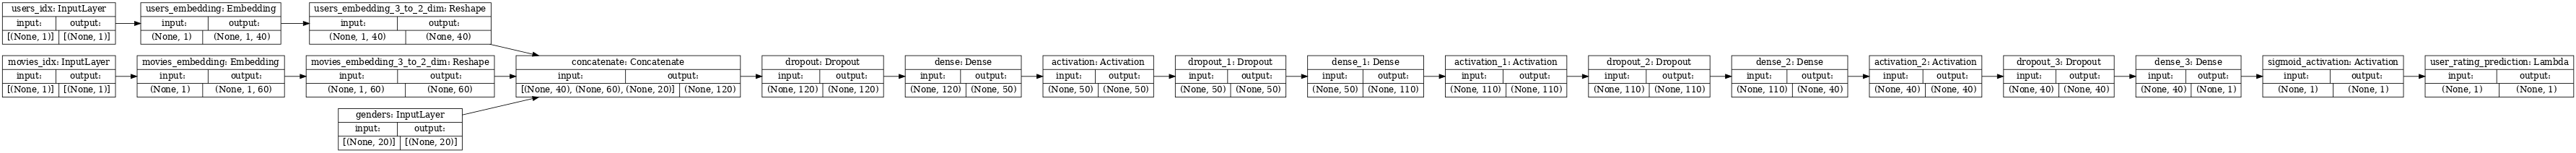

In [45]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
plot_model(tuner.hypermodel.build(best_hps))

In [46]:
# model.summary()

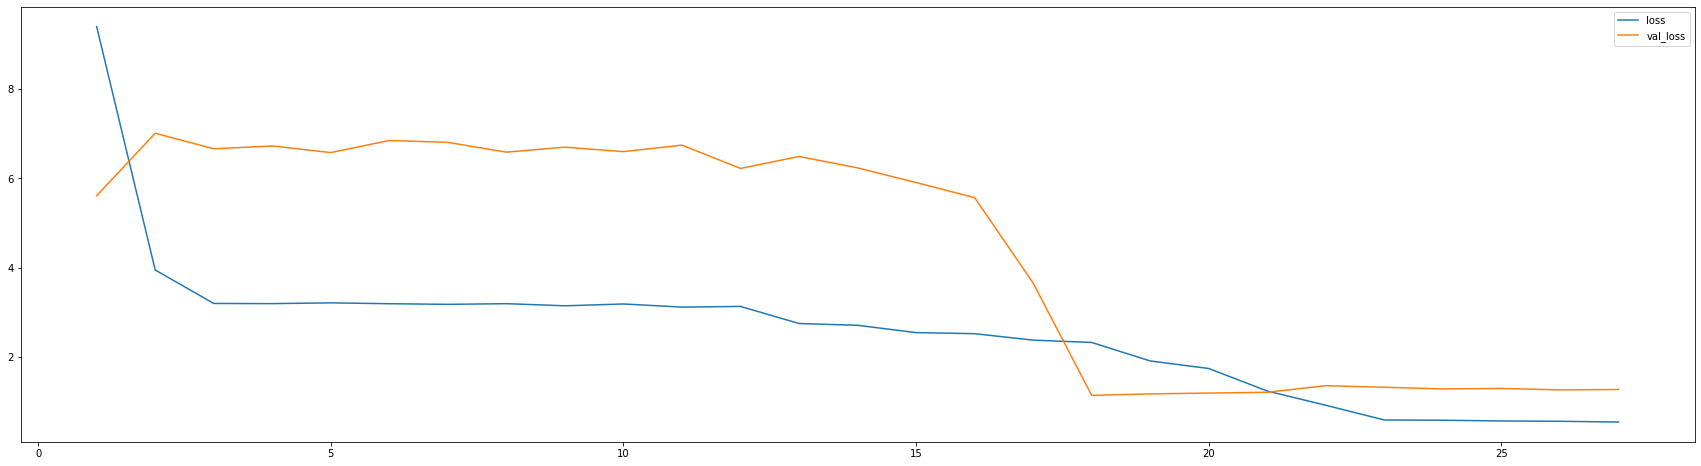

 52/100 [==============>...............] - ETA: 4s - loss: 0.5506

Evaluate model each 51 steps(Batch-size: 3033):
1/1 [==============================] - 0s 16ms/step - loss: 1.2541

Val metrics:
  - Loss (28): 1.254086 (⟱ 0.01685333)

Continue model train:
100/100 [==============================] - 10s 98ms/step - loss: 0.5467 - val_loss: 1.2886


In [58]:
model    = tuner.hypermodel.build(best_hps)

history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[
        create_metrics_callback(), 
        create_checkpoints_callback(),
        EarlyStopping(monitor='val_loss', patience=5)
    ],
    verbose=1
)

In [59]:
evaluate(model, train_set, batch_size=train_batch_size)

0.30963534116744995

In [60]:
evaluate(model, val_set, batch_size=val_batch_size)

1.2679753303527832

In [61]:
evaluate(model, test_set, batch_size=val_batch_size)

1.0361087322235107

In [62]:
val_loss_per_epoch = history.history['val_loss']

best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1

print(f'Best epoch: {best_epoch}')

Best epoch: 9


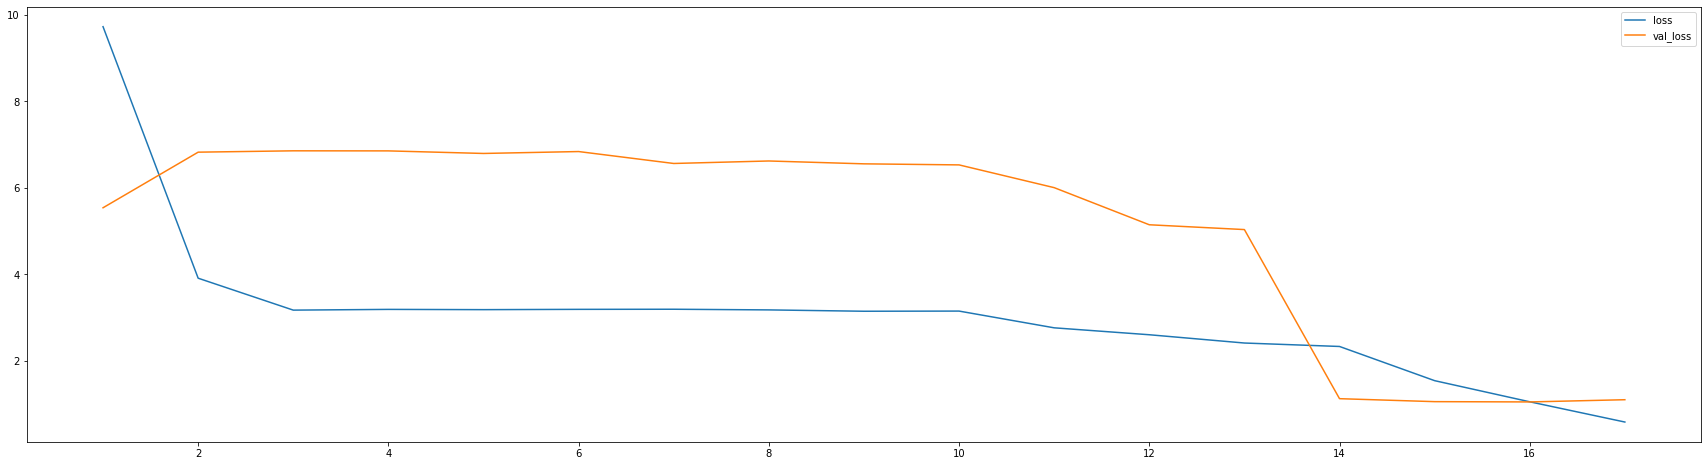

 52/100 [==============>...............] - ETA: 4s - loss: 0.5770

Evaluate model each 51 steps(Batch-size: 3033):
1/1 [==============================] - 0s 17ms/step - loss: 1.0767

Val metrics:
  - Loss (18): 1.076703 (⟱ 0.02676678)

Continue model train:
100/100 [==============================] - 10s 97ms/step - loss: 0.5517 - val_loss: 1.1024


In [63]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model    = tuner.hypermodel.build(best_hps)

history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs=best_epoch,
    callbacks=[
        create_metrics_callback(), 
        create_checkpoints_callback(),
        EarlyStopping(monitor='val_loss', patience=5)
    ],
    verbose=1
)

In [64]:
evaluate(model, train_set, batch_size=train_batch_size)

0.2478983998298645

In [65]:
evaluate(model, val_set, batch_size=val_batch_size)

1.058815836906433

In [66]:
evaluate(model, test_set, batch_size=val_batch_size)

0.91874098777771